In [ ]:
pip install open-clip-torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


In [ ]:
pip install gtts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.2.0
    Uninstalling click-8.2.0:
      Successfully uninstalled click-8.2.0


In [ ]:
# navigation_robot_system.py
"""Navigation‑aware robot assistant built on Microsoft Magma‑8B.

scene description, navigation guidance, hazard spotting, TTS—while adding
an *action‑plan* generator so a mobile robot can follow step‑by‑step
instructions to fulfil a goal (e.g. “Go near the woman in the kitchen”).

All heavy lifting is done by Magma‑8B through carefully crafted prompts.
The code is designed for Google Colab (so webcam capture and file download
helpers use Colab APIs) but will run elsewhere if you replace those parts.
"""

from __future__ import annotations

import base64
import json
import os
import time
from io import BytesIO
from typing import List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from gtts import gTTS
from IPython.display import Audio, Javascript, display
from transformers import AutoModelForCausalLM, AutoProcessor

# ---------------------------------------------------------------------------
#  Base class: NavigationSupportSystem
# ---------------------------------------------------------------------------

class NavigationSupportSystem:
    """Visual interpreter that speaks out a scene, warns of hazards and gives
    general guidance.  All generation is delegated to Magma‑8B (vision‑LLM)."""

    # ------------------------------------------------------------------
    # Initialisation / model loading
    # ------------------------------------------------------------------
    def __init__(self, model_name: str = "microsoft/Magma-8B") -> None:
        print("🔄 Initialising Navigation Support System …")
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.dtype = torch.bfloat16

        print(f"🔻 Loading {model_name} on {self.device} …")
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name, trust_remote_code=True, torch_dtype=self.dtype
        ).to(self.device)
        self.processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
        print("✅ Model ready.")

        # Runtime artefacts & history
        self.results_dir = "navigation_robot_results"
        os.makedirs(self.results_dir, exist_ok=True)
        self.history: List[dict] = []

        # User‑tuneable behaviour flags
        self.settings = {
            "description_detail": "high",   # low | medium | high
            "guidance_detail": "high",      # low | medium | high
            "action_detail": "high",        # low | medium | high (used by subclass)
            "hazard_priority": True,         # check hazards first
            "landmarks_focus": True,
            "voice_speed": 1.0,              # TTS speed multiplier
            "max_waypoints": 10,             # cap for plan length
        }

    # ------------------------------------------------------------------
    # Camera helper (Colab) ------------------------------------------------
    # ------------------------------------------------------------------
    def _take_photo_colab(self) -> Image.Image:
        """Capture an image from the user’s webcam (Colab only)."""
        from google.colab.output import eval_js  # type: ignore

        display(Javascript(r"""
        async function takePhoto(){
          const div=document.createElement('div');
          const btn=document.createElement('button');btn.textContent='Capture';div.appendChild(btn);
          const video=document.createElement('video');div.appendChild(video);
          document.body.appendChild(div);
          const stream=await navigator.mediaDevices.getUserMedia({video:true});video.srcObject=stream;await video.play();
          await new Promise(r=>btn.onclick=r);
          const canvas=document.createElement('canvas');canvas.width=video.videoWidth;canvas.height=video.videoHeight;
          canvas.getContext('2d').drawImage(video,0,0);
          stream.getVideoTracks()[0].stop();div.remove();
          return canvas.toDataURL('image/jpeg');
        }
        """))
        data_uri = eval_js('takePhoto()')
        binary = base64.b64decode(data_uri.split(',')[1])
        return Image.open(BytesIO(binary))

    # ------------------------------------------------------------------
    # Small internal helper to DRY generation calls ----------------------
    # ------------------------------------------------------------------
    def _generate(self, convs: List[dict], image: Image.Image, max_tokens: int) -> str:
        prompt = self.processor.tokenizer.apply_chat_template(convs, tokenize=False, add_generation_prompt=True)
        inputs = self.processor(images=[image], texts=prompt, return_tensors="pt")
        inputs["pixel_values"] = inputs["pixel_values"].unsqueeze(0)
        inputs["image_sizes"] = inputs["image_sizes"].unsqueeze(0)
        inputs = inputs.to(self.device).to(self.dtype)
        with torch.inference_mode():
            gen_ids = self.model.generate(
                **inputs, max_new_tokens=max_tokens, temperature=0.2, do_sample=True, num_beams=1
            )
        gen_ids = gen_ids[:, inputs["input_ids"].shape[-1]:]
        return self.processor.decode(gen_ids[0], skip_special_tokens=True).strip()

    # ------------------------------------------------------------------
    # Core perceptual methods -------------------------------------------
    # ------------------------------------------------------------------
    def describe_environment(self, image: Image.Image) -> str:
        level = self.settings["description_detail"]
        sys = "You are an assistive system for Navigation. When given an image, describe the environment in detail"
        if self.settings["hazard_priority"]:
            sys += ", prioritising potential hazards and obstacles"
        if self.settings["landmarks_focus"]:
            sys += ", emphasising landmarks that can be used for orientation"
        sys += "."

        if level == "low":
            user = "<image_start><image><image_end>\nI'm blind. Briefly describe the key elements I must know."
            max_tok = 200
        elif level == "medium":
            user = "<image_start><image><image_end>\nI'm blind. Describe obstacles, paths and key objects with moderate detail."
            max_tok = 350
        else:
            user = (
                "<image_start><image><image_end>\nI'm blind. Give a comprehensive description, including spatial relationships "
                "and distances. Focus on obstacles, paths, people and objects I should be aware of."
            )
            max_tok = 500

        return self._generate([{"role": "system", "content": sys}, {"role": "user", "content": user}], image, max_tok)

    def provide_guidance(self, image: Image.Image) -> str:
        level = self.settings["guidance_detail"]
        sys = "You are an assistive navigation system for blind people. Provide clear navigation instructions."
        if level == "low":
            user = "<image_start><image><image_end>\nBriefly tell me immediate obstacles and the safe path forward."
            max_tok = 200
        elif level == "medium":
            user = "<image_start><image><image_end>\nGuide me, including obstacles to avoid, safe paths and nearby landmarks."
            max_tok = 350
        else:
            user = (
                "<image_start><image><image_end>\nProvide detailed guidance: safe paths, distances to obstacles, potential hazards "
                "and landmarks with clock‑direction wording."
            )
            max_tok = 500
        return self._generate([{"role": "system", "content": sys}, {"role": "user", "content": user}], image, max_tok)

    def detect_hazards(self, image: Image.Image) -> Optional[str]:
        sys = "You are a safety system for blind people. Identify ONLY potential hazards or dangerous obstacles."
        user = "<image_start><image><image_end>\nList immediate hazards in order of danger level."
        resp = self._generate([{"role": "system", "content": sys}, {"role": "user", "content": user}], image, 250)
        if any(x in resp.lower() for x in ("no hazard", "safe environment", "no danger")):
            return None
        return resp

    # ------------------------------------------------------------------
    # Text‑to‑speech -----------------------------------------------------
    # ------------------------------------------------------------------
    def _tts(self, text: str, speed: float | None = None) -> Audio:
        speed = self.settings["voice_speed"] if speed is None else speed
        slow = speed < 1.0
        tts = gTTS(text=text, lang="en", slow=slow)
        path = os.path.join(self.results_dir, "speech.mp3")
        tts.save(path)
        return Audio(path, autoplay=True, rate=speed)


# ---------------------------------------------------------------------------
#  Extended class: NavigationRobotSystem
# ---------------------------------------------------------------------------

class NavigationRobotSystem(NavigationSupportSystem):
    """Adds goal‑directed action planning to NavigationSupportSystem."""

    # ---------------------------------------------------------------
    # Action‑plan generator
    # ---------------------------------------------------------------
    def plan_actions(self, image: Image.Image, task: str) -> str:
        level = self.settings["action_detail"]
        max_tok = {"low": 256, "medium": 384, "high": 512}[level]
        sys = (
            "You are an autonomous navigation planner for an indoor service robot. "
            "Return a concise, numbered list of steps that allows the robot to fulfil "
            "the given task, using relative directions (clock positions), distances, "
            "and landmarks. Finish with 'Task accomplished'."
        )
        user = (
            f"<image_start><image><image_end>\nTask: {task}. Provide no more than {self.settings['max_waypoints']} steps."
        )
        return self._generate([{"role": "system", "content": sys}, {"role": "user", "content": user}], image, max_tok)

    # ---------------------------------------------------------------
    # High‑level routine: process image + task ----------------------
    # ---------------------------------------------------------------
    def process_task(
        self,
        image_source: str = "webcam",
        task: str = "Navigate to the door",
        save_results: bool = True,
    ) -> Tuple[str, str, str, Optional[str], Audio]:
        """Capture or load an image, then generate description, guidance, hazards & plan."""
        ts = time.strftime("%Y%m%d_%H%M%S")

        # 1️⃣ Acquire image --------------------------------------------------
        if image_source == "webcam":
            print("📷 Allow webcam and press *Capture* …")
            img = self._take_photo_colab()
            img_path = os.path.join(self.results_dir, f"capture_{ts}.jpg")
            img.save(img_path)
        elif image_source == "upload":
            from google.colab import files  # type: ignore

            uploaded = files.upload()
            filename = next(iter(uploaded))
            img = Image.open(filename)
            img_path = filename
        else:
            img_path = image_source
            img = Image.open(img_path)

        plt.figure(figsize=(8, 6)); plt.imshow(np.array(img)); plt.axis("off"); plt.title("Input image"); plt.show()

        # 2️⃣ Perception & reasoning ---------------------------------------
        start = time.time()
        hazards = self.detect_hazards(img) if self.settings["hazard_priority"] else None
        description = self.describe_environment(img)
        guidance = self.provide_guidance(img)
        plan = self.plan_actions(img, task)
        elapsed = time.time() - start

        # 3️⃣ Console output -------------------------------------------------
        print("\n📝 Description:\n", description)
        print("\n🧭 Guidance:\n", guidance)
        print("\n🗺️  Action plan:\n", plan)
        if hazards:
            print("\n⚠️ Hazards:\n", hazards)
        print(f"\n⏱️ Done in {elapsed:.1f}s")

        # 4️⃣ Speech --------------------------------------------------------
        speech_txt = ""
        if hazards:
            speech_txt += f"Warning! {hazards}. "
        speech_txt += f"Environment: {description}. Guidance: {guidance}. Action plan: {plan}"
        audio = self._tts(speech_txt)

        # 5️⃣ Save log ------------------------------------------------------
        if save_results:
            record = {
                "timestamp": ts,
                "image": os.path.basename(img_path),
                "task": task,
                "description": description,
                "guidance": guidance,
                "plan": plan,
                "hazards": hazards,
                "processing_time": elapsed,
                "settings": self.settings.copy(),
            }
            self.history.append(record)
            with open(os.path.join(self.results_dir, f"result_{ts}.json"), "w") as f:
                json.dump(record, f, indent=2)

        return description, guidance, plan, hazards, audio


# ---------------------------------------------------------------------------
# Example usage (commented out)
# ---------------------------------------------------------------------------
# if __name__ == "__main__":
#     nrs = NavigationRobotSystem()
#     nrs.process_task("upload", task="Go near the woman in the kitchen")


🔄 Initialising Navigation Support System …
🔻 Loading microsoft/Magma-8B on cuda …


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/3.25k [00:00<?, ?B/s]

configuration_magma.py:   0%|          | 0.00/7.60k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Magma-8B:
- configuration_magma.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_magma.py:   0%|          | 0.00/75.6k [00:00<?, ?B/s]

image_tower_magma.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Magma-8B:
- image_tower_magma.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/microsoft/Magma-8B:
- modeling_magma.py
- image_tower_magma.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.91G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/4.80G [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of MagmaForCausalLM were not initialized from the model checkpoint at microsoft/Magma-8B and are newly initialized: ['vision_tower.clip_vision_model.head.proj.weight', 'vision_tower.clip_vision_model.trunk.head.norm.bias', 'vision_tower.clip_vision_model.trunk.head.norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/478 [00:00<?, ?B/s]

processing_magma.py:   0%|          | 0.00/7.77k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Magma-8B:
- processing_magma.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


image_processing_magma.py:   0%|          | 0.00/11.2k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/auto/image_processing_auto.py:604: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

✅ Model ready.


Saving home.jpg to home.jpg


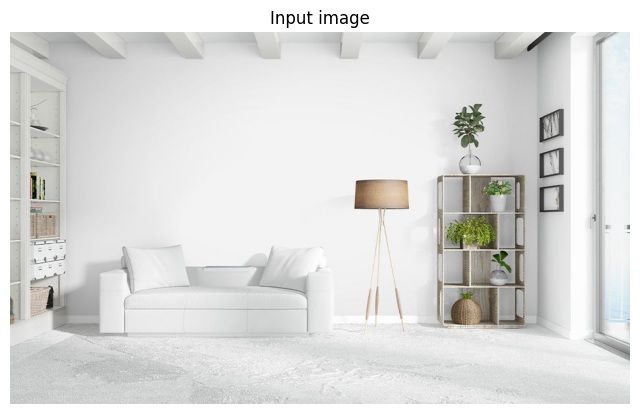

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.



📝 Description:
 The image presents a serene and minimalist living room. Dominating the center of the room is a white sofa, adorned with two white throw pillows. The sofa faces a white coffee table, which holds a single white lamp. To the right of the sofa, a white bookshelf stands tall, housing an array of books and plants. On the left side of the sofa, a white side table holds a white vase filled with greenery. The walls of the room are painted white, providing a clean backdrop for the white ceiling. Underfoot, a white rug covers the floor, adding a touch of warmth to the space. The room is devoid of any human presence, creating an atmosphere of tranquility.

🧭 Guidance:
 No safe paths found.

🗺️  Action plan:
 Mark 1 at [53,21]. Mark 2 at [53,21]. Mark 3 at [53,21]. Mark 4 at [53,21]. Mark 5 at [53,21]. Mark 6 at [53,21]. Mark 7 at [53,21]. Mark 8 at [53,21]

⚠️ Hazards:
 No immediate hazards found.

⏱️ Done in 10.5s


In [ ]:

if __name__ == "__main__":
    nrs = NavigationRobotSystem()
    nrs.process_task("upload", task="Go near the woman in the kitchen")

Saving Kitchen.jpg to Kitchen.jpg


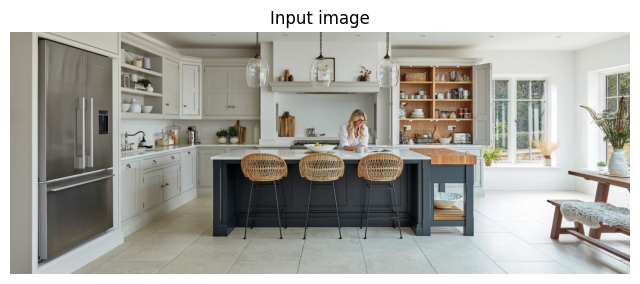

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:745: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



📝 Description:
 The image captures a modern kitchen bathed in natural light from a large window on the right. The kitchen is a blend of functionality and style, with a stainless steel refrigerator standing tall on the left, a black island in the center serving as a hub for culinary adventures, and a wooden dining table on the right. 

Three wicker barstools are tucked neatly under the island, ready to provide a comfortable seating arrangement for those who wish to dine at the island. The kitchen is well-equipped with white cabinets that line the walls, providing ample storage space. 

Adding a touch of greenery to the space, several potted plants are scattered throughout the kitchen, their vibrant colors contrasting beautifully with the white and black color scheme of the room. The overall layout of the kitchen suggests a space designed for both cooking and dining, with every element thoughtfully placed for maximum efficiency.

🧭 Guidance:
 1. The woman is seated at the kitchen island

('The image captures a modern kitchen bathed in natural light from a large window on the right. The kitchen is a blend of functionality and style, with a stainless steel refrigerator standing tall on the left, a black island in the center serving as a hub for culinary adventures, and a wooden dining table on the right. \n\nThree wicker barstools are tucked neatly under the island, ready to provide a comfortable seating arrangement for those who wish to dine at the island. The kitchen is well-equipped with white cabinets that line the walls, providing ample storage space. \n\nAdding a touch of greenery to the space, several potted plants are scattered throughout the kitchen, their vibrant colors contrasting beautifully with the white and black color scheme of the room. The overall layout of the kitchen suggests a space designed for both cooking and dining, with every element thoughtfully placed for maximum efficiency.',
 '1. The woman is seated at the kitchen island, which is equipped w

In [ ]:
 nrs.process_task("upload", task="Is it possible to movw towards the woman?")